# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [26]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [27]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [28]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [29]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # get training and test directories
    img_path = './' + data_dir

    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(img_path, transform)

    # create and return DataLoaders
    img_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

    return img_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [30]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

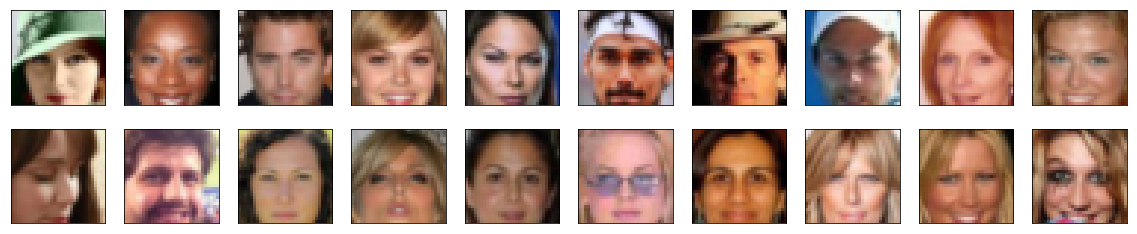

In [31]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [32]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min   
    return x


In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [36]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, stride=2, padding=1, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4, stride=2, padding=1, batch_norm=True)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2, padding=1, batch_norm=True)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [37]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [38]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [39]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    
    mean = 0.0
    std = 0.02
    
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, mean, std)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [41]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [43]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # real labels = 1
    labels = torch.ones(batch_size) 
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''  
    batch_size = D_out.size(0)
    # fake labels = 0
    labels = torch.zeros(batch_size) 
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [44]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [45]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        if train_on_gpu:
            fixed_z = fixed_z.cuda()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [46]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4407 | g_loss: 0.9791
Epoch [    1/   50] | d_loss: 0.3781 | g_loss: 2.3779
Epoch [    1/   50] | d_loss: 0.1219 | g_loss: 3.6329
Epoch [    1/   50] | d_loss: 0.2924 | g_loss: 2.6204
Epoch [    1/   50] | d_loss: 0.2234 | g_loss: 3.4906
Epoch [    1/   50] | d_loss: 0.7084 | g_loss: 5.4579
Epoch [    1/   50] | d_loss: 0.4653 | g_loss: 1.7654
Epoch [    1/   50] | d_loss: 0.5880 | g_loss: 2.5766
Epoch [    1/   50] | d_loss: 0.6384 | g_loss: 2.3092
Epoch [    1/   50] | d_loss: 0.5292 | g_loss: 1.5300
Epoch [    1/   50] | d_loss: 0.7518 | g_loss: 1.2579
Epoch [    1/   50] | d_loss: 0.8551 | g_loss: 1.6899
Epoch [    1/   50] | d_loss: 0.8223 | g_loss: 1.8787
Epoch [    1/   50] | d_loss: 0.8021 | g_loss: 1.9758
Epoch [    1/   50] | d_loss: 0.8178 | g_loss: 1.2911
Epoch [    1/   50] | d_loss: 0.8453 | g_loss: 1.5283
Epoch [    1/   50] | d_loss: 1.1924 | g_loss: 2.2478
Epoch [    1/   50] | d_loss: 0.7917 | g_loss: 1.7857
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.8884 | g_loss: 1.0243
Epoch [    6/   50] | d_loss: 0.8224 | g_loss: 1.3942
Epoch [    6/   50] | d_loss: 1.0041 | g_loss: 1.1552
Epoch [    6/   50] | d_loss: 0.8437 | g_loss: 1.3372
Epoch [    6/   50] | d_loss: 1.0210 | g_loss: 1.3186
Epoch [    6/   50] | d_loss: 0.5244 | g_loss: 2.2767
Epoch [    6/   50] | d_loss: 1.1384 | g_loss: 1.8302
Epoch [    6/   50] | d_loss: 0.8927 | g_loss: 1.1997
Epoch [    6/   50] | d_loss: 1.1166 | g_loss: 0.7362
Epoch [    6/   50] | d_loss: 1.0457 | g_loss: 1.0411
Epoch [    6/   50] | d_loss: 1.1399 | g_loss: 0.6603
Epoch [    6/   50] | d_loss: 0.8245 | g_loss: 1.3695
Epoch [    6/   50] | d_loss: 1.0739 | g_loss: 1.4967
Epoch [    6/   50] | d_loss: 0.8940 | g_loss: 1.0680
Epoch [    6/   50] | d_loss: 0.9176 | g_loss: 1.2493
Epoch [    6/   50] | d_loss: 0.8654 | g_loss: 1.2283
Epoch [    6/   50] | d_loss: 0.9348 | g_loss: 1.4573
Epoch [    6/   50] | d_loss: 0.8737 | g_loss: 0.9635
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 1.6075 | g_loss: 2.2821
Epoch [   11/   50] | d_loss: 0.8194 | g_loss: 1.5099
Epoch [   11/   50] | d_loss: 0.6358 | g_loss: 1.7132
Epoch [   11/   50] | d_loss: 0.5707 | g_loss: 2.2760
Epoch [   11/   50] | d_loss: 0.7775 | g_loss: 2.6132
Epoch [   11/   50] | d_loss: 0.4981 | g_loss: 1.3619
Epoch [   11/   50] | d_loss: 0.4482 | g_loss: 2.4686
Epoch [   11/   50] | d_loss: 0.5381 | g_loss: 1.8043
Epoch [   11/   50] | d_loss: 0.4871 | g_loss: 2.6139
Epoch [   11/   50] | d_loss: 1.0104 | g_loss: 1.1208
Epoch [   11/   50] | d_loss: 0.4672 | g_loss: 1.8847
Epoch [   11/   50] | d_loss: 0.6912 | g_loss: 1.3043
Epoch [   11/   50] | d_loss: 0.5942 | g_loss: 2.0174
Epoch [   11/   50] | d_loss: 0.6333 | g_loss: 1.7862
Epoch [   11/   50] | d_loss: 0.4987 | g_loss: 1.6125
Epoch [   12/   50] | d_loss: 1.7307 | g_loss: 3.4515
Epoch [   12/   50] | d_loss: 0.6942 | g_loss: 1.4423
Epoch [   12/   50] | d_loss: 0.4722 | g_loss: 2.0886
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.3193 | g_loss: 2.8611
Epoch [   16/   50] | d_loss: 0.3739 | g_loss: 1.2268
Epoch [   16/   50] | d_loss: 0.2310 | g_loss: 2.6832
Epoch [   16/   50] | d_loss: 0.2193 | g_loss: 2.6688
Epoch [   16/   50] | d_loss: 0.2850 | g_loss: 2.8526
Epoch [   16/   50] | d_loss: 0.4836 | g_loss: 2.7480
Epoch [   16/   50] | d_loss: 1.2167 | g_loss: 5.4026
Epoch [   16/   50] | d_loss: 0.4325 | g_loss: 2.5675
Epoch [   17/   50] | d_loss: 0.4055 | g_loss: 2.8596
Epoch [   17/   50] | d_loss: 0.3907 | g_loss: 1.9621
Epoch [   17/   50] | d_loss: 0.4273 | g_loss: 2.0669
Epoch [   17/   50] | d_loss: 0.4267 | g_loss: 1.9102
Epoch [   17/   50] | d_loss: 0.2642 | g_loss: 2.0394
Epoch [   17/   50] | d_loss: 0.7351 | g_loss: 3.1812
Epoch [   17/   50] | d_loss: 0.3054 | g_loss: 1.9069
Epoch [   17/   50] | d_loss: 0.3734 | g_loss: 2.7392
Epoch [   17/   50] | d_loss: 0.3974 | g_loss: 2.7870
Epoch [   17/   50] | d_loss: 0.4124 | g_loss: 2.5370
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.2613 | g_loss: 2.6842
Epoch [   22/   50] | d_loss: 0.3798 | g_loss: 2.9668
Epoch [   22/   50] | d_loss: 0.2121 | g_loss: 2.4998
Epoch [   22/   50] | d_loss: 0.3574 | g_loss: 2.7792
Epoch [   22/   50] | d_loss: 0.3367 | g_loss: 2.5437
Epoch [   22/   50] | d_loss: 0.2695 | g_loss: 2.7874
Epoch [   22/   50] | d_loss: 0.1974 | g_loss: 2.5262
Epoch [   22/   50] | d_loss: 0.3234 | g_loss: 3.2020
Epoch [   22/   50] | d_loss: 0.3687 | g_loss: 2.2409
Epoch [   22/   50] | d_loss: 0.2308 | g_loss: 1.8307
Epoch [   22/   50] | d_loss: 0.1476 | g_loss: 3.0344
Epoch [   22/   50] | d_loss: 0.2943 | g_loss: 2.5057
Epoch [   22/   50] | d_loss: 0.1162 | g_loss: 3.6881
Epoch [   22/   50] | d_loss: 0.2508 | g_loss: 3.7864
Epoch [   22/   50] | d_loss: 0.6196 | g_loss: 3.8186
Epoch [   22/   50] | d_loss: 0.2383 | g_loss: 2.3902
Epoch [   22/   50] | d_loss: 0.2252 | g_loss: 2.7089
Epoch [   22/   50] | d_loss: 0.2471 | g_loss: 3.8419
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.1789 | g_loss: 2.2187
Epoch [   27/   50] | d_loss: 0.2222 | g_loss: 3.8750
Epoch [   27/   50] | d_loss: 0.1505 | g_loss: 4.7427
Epoch [   27/   50] | d_loss: 0.2783 | g_loss: 2.7702
Epoch [   27/   50] | d_loss: 0.1835 | g_loss: 2.3174
Epoch [   27/   50] | d_loss: 0.2723 | g_loss: 2.2240
Epoch [   27/   50] | d_loss: 0.2735 | g_loss: 3.0811
Epoch [   27/   50] | d_loss: 2.0011 | g_loss: 0.8571
Epoch [   27/   50] | d_loss: 0.1294 | g_loss: 3.9521
Epoch [   27/   50] | d_loss: 0.1798 | g_loss: 2.0673
Epoch [   27/   50] | d_loss: 0.1835 | g_loss: 3.7117
Epoch [   27/   50] | d_loss: 0.2176 | g_loss: 3.8253
Epoch [   27/   50] | d_loss: 0.1643 | g_loss: 2.2182
Epoch [   27/   50] | d_loss: 0.1504 | g_loss: 2.6792
Epoch [   27/   50] | d_loss: 0.1467 | g_loss: 3.5089
Epoch [   27/   50] | d_loss: 0.1902 | g_loss: 3.6539
Epoch [   27/   50] | d_loss: 0.2181 | g_loss: 2.9217
Epoch [   27/   50] | d_loss: 0.1753 | g_loss: 3.2904
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.1492 | g_loss: 2.7765
Epoch [   32/   50] | d_loss: 0.2285 | g_loss: 3.2838
Epoch [   32/   50] | d_loss: 0.1365 | g_loss: 4.3482
Epoch [   32/   50] | d_loss: 0.3398 | g_loss: 2.3815
Epoch [   32/   50] | d_loss: 0.2644 | g_loss: 2.8402
Epoch [   32/   50] | d_loss: 0.1851 | g_loss: 3.0900
Epoch [   32/   50] | d_loss: 0.1496 | g_loss: 3.7441
Epoch [   32/   50] | d_loss: 1.5737 | g_loss: 3.6960
Epoch [   32/   50] | d_loss: 1.0857 | g_loss: 1.3643
Epoch [   32/   50] | d_loss: 0.3293 | g_loss: 5.6915
Epoch [   32/   50] | d_loss: 0.1439 | g_loss: 2.6287
Epoch [   32/   50] | d_loss: 0.1550 | g_loss: 3.5837
Epoch [   32/   50] | d_loss: 0.1438 | g_loss: 3.5974
Epoch [   32/   50] | d_loss: 0.1037 | g_loss: 3.9821
Epoch [   32/   50] | d_loss: 0.2602 | g_loss: 3.7904
Epoch [   32/   50] | d_loss: 0.3203 | g_loss: 3.2542
Epoch [   33/   50] | d_loss: 0.1590 | g_loss: 2.5984
Epoch [   33/   50] | d_loss: 0.3240 | g_loss: 1.9344
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.3733 | g_loss: 2.8034
Epoch [   37/   50] | d_loss: 0.2411 | g_loss: 3.8888
Epoch [   37/   50] | d_loss: 0.1888 | g_loss: 3.8684
Epoch [   37/   50] | d_loss: 0.0735 | g_loss: 2.8812
Epoch [   37/   50] | d_loss: 0.0908 | g_loss: 4.6619
Epoch [   37/   50] | d_loss: 0.1300 | g_loss: 3.7108
Epoch [   37/   50] | d_loss: 0.4190 | g_loss: 3.0878
Epoch [   37/   50] | d_loss: 0.1493 | g_loss: 3.9162
Epoch [   37/   50] | d_loss: 0.1388 | g_loss: 2.8733
Epoch [   38/   50] | d_loss: 0.2987 | g_loss: 4.4016
Epoch [   38/   50] | d_loss: 1.8247 | g_loss: 1.8905
Epoch [   38/   50] | d_loss: 0.1511 | g_loss: 4.5430
Epoch [   38/   50] | d_loss: 0.2065 | g_loss: 3.6761
Epoch [   38/   50] | d_loss: 0.1254 | g_loss: 4.0128
Epoch [   38/   50] | d_loss: 0.1638 | g_loss: 3.7235
Epoch [   38/   50] | d_loss: 0.1092 | g_loss: 3.9652
Epoch [   38/   50] | d_loss: 0.1190 | g_loss: 2.9991
Epoch [   38/   50] | d_loss: 0.1489 | g_loss: 4.3442
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.2126 | g_loss: 3.6509
Epoch [   42/   50] | d_loss: 0.1344 | g_loss: 3.1047
Epoch [   43/   50] | d_loss: 0.2356 | g_loss: 4.6541
Epoch [   43/   50] | d_loss: 0.0789 | g_loss: 4.6592
Epoch [   43/   50] | d_loss: 0.0599 | g_loss: 5.0344
Epoch [   43/   50] | d_loss: 0.1617 | g_loss: 3.6839
Epoch [   43/   50] | d_loss: 0.1195 | g_loss: 2.7794
Epoch [   43/   50] | d_loss: 0.0962 | g_loss: 4.9841
Epoch [   43/   50] | d_loss: 0.0777 | g_loss: 4.7265
Epoch [   43/   50] | d_loss: 0.0721 | g_loss: 4.9283
Epoch [   43/   50] | d_loss: 0.0686 | g_loss: 4.3253
Epoch [   43/   50] | d_loss: 0.0953 | g_loss: 4.8181
Epoch [   43/   50] | d_loss: 0.5532 | g_loss: 5.8795
Epoch [   43/   50] | d_loss: 0.1263 | g_loss: 4.0618
Epoch [   43/   50] | d_loss: 0.2066 | g_loss: 3.5720
Epoch [   43/   50] | d_loss: 0.1385 | g_loss: 3.7541
Epoch [   43/   50] | d_loss: 0.0827 | g_loss: 4.6396
Epoch [   43/   50] | d_loss: 0.0973 | g_loss: 3.4543
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.1101 | g_loss: 3.8727
Epoch [   48/   50] | d_loss: 0.1656 | g_loss: 4.5319
Epoch [   48/   50] | d_loss: 0.0543 | g_loss: 4.0264
Epoch [   48/   50] | d_loss: 0.1407 | g_loss: 3.6877
Epoch [   48/   50] | d_loss: 1.5612 | g_loss: 0.6304
Epoch [   48/   50] | d_loss: 0.2689 | g_loss: 2.3586
Epoch [   48/   50] | d_loss: 0.1202 | g_loss: 3.9474
Epoch [   48/   50] | d_loss: 0.0755 | g_loss: 4.1763
Epoch [   48/   50] | d_loss: 0.1146 | g_loss: 4.7329
Epoch [   48/   50] | d_loss: 0.0882 | g_loss: 4.1372
Epoch [   48/   50] | d_loss: 0.0805 | g_loss: 3.5526
Epoch [   48/   50] | d_loss: 0.1525 | g_loss: 3.8943
Epoch [   48/   50] | d_loss: 0.0439 | g_loss: 5.1347
Epoch [   48/   50] | d_loss: 0.0741 | g_loss: 4.6087
Epoch [   48/   50] | d_loss: 0.1649 | g_loss: 3.6669
Epoch [   48/   50] | d_loss: 0.0893 | g_loss: 3.8770
Epoch [   48/   50] | d_loss: 0.7600 | g_loss: 2.1926
Epoch [   48/   50] | d_loss: 0.1311 | g_loss: 3.2766
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

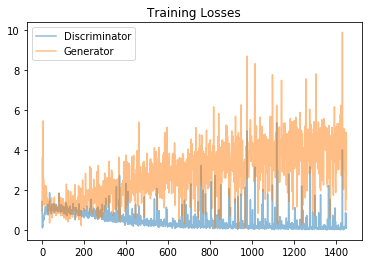

In [51]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [48]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [49]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

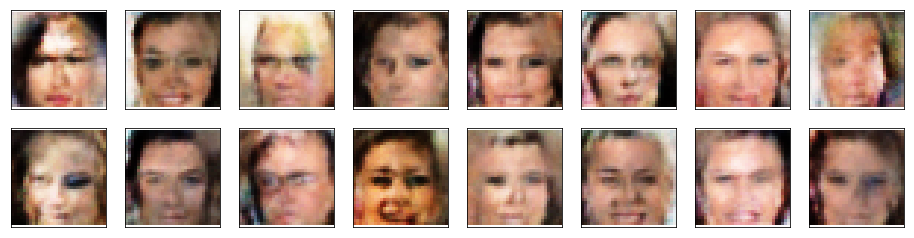

In [65]:
_ = view_samples(1, samples)

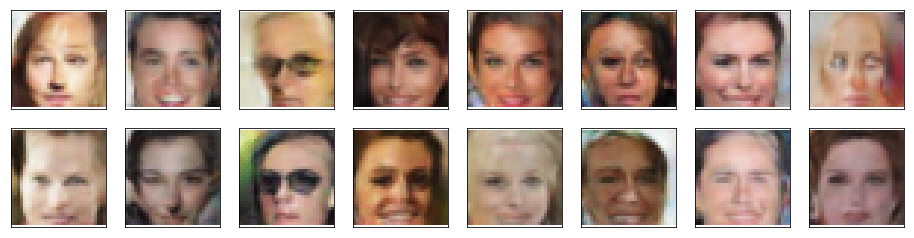

In [66]:
_ = view_samples(20, samples)

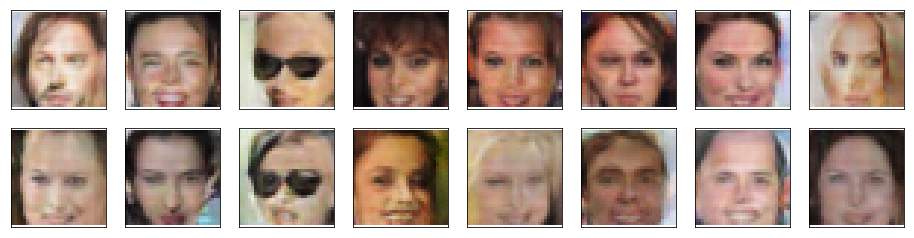

In [67]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

The model generates recognizable human faces after only one epoch, but later the faces will be more realistic and clearer, but not clear enough, after 50 epoch they are quite blurred. In some images, parts of the face are too large, or small, but in most pictures the features are believable.

The 32x32 pixel size isn't too large, and in my generator, I used only three convolutional layers. With larger images and more layers, the model would be able to learn more features.

With this model, we don't know if the output will be a woman or a man, and in the above example, all faces are white. We could split the training data according to our desired goal faces and we could train distinct models for white females or black males or any other variations.

With a lot of work, we could add to the training images of different labels like blond_hair, black_hair, large_nose, small_nose, bald, mustached. . .  and try to find out what kind of input arrays would give us the desired bald, mustached hero.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.